## This is my practice tutorial for the final project

## Here we will use the astropy as our fits reader

In [45]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

## Here we will open our FITS file

In [46]:
fname = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu_list = fits.open(fname)
hdu_list.info()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


## Gather information from the PRIMARY block using hdu_list

In [47]:
image_data = hdu_list[0].data

## To gather dimensions of the image we will look at the shape of the array

In [48]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(3600, 3600)


## Close the FITS file, everything was stored to a variable

In [49]:
hdu_list.close()

## A shortcut [getdata()] to just read in the image data and close the file

In [50]:
image_data = fits.getdata(fname)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(3600, 3600)


## Show the image

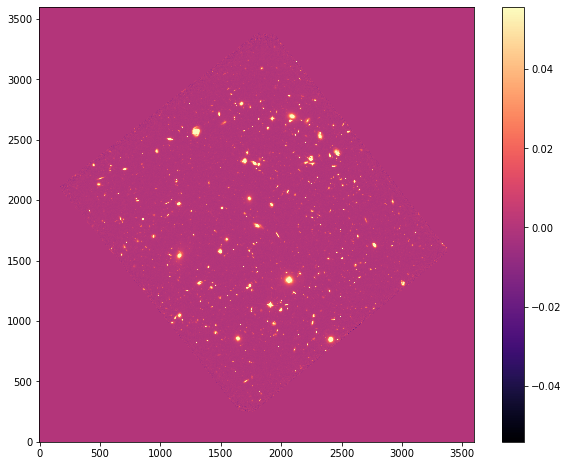

In [51]:
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='magma', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

## Subtract the background data before sources can be detected with separate steps

In [52]:
#measure a spatially varying background on the image
image_data = image_data.byteswap(False).newbyteorder()
bkg = sep.Background(image_data)

## Basic statistics about our image:

In [53]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: -0.9047293
Max: 74.44648
Mean: 0.00079129904
Stdev: 0.054868452


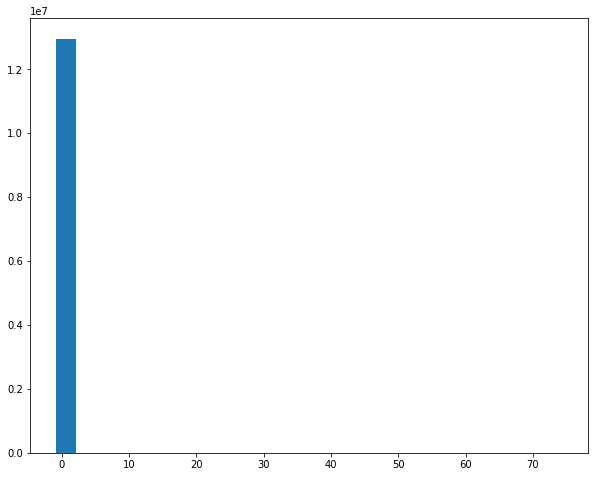

In [54]:
histogram = plt.hist(image_data.flatten(), bins='auto')

In [68]:
from matplotlib.colors import LogNorm

[Text(1, 5000.0, '5,000'),
 Text(1, 10000.0, '10,000'),
 Text(1, 20000.0, '20,000')]

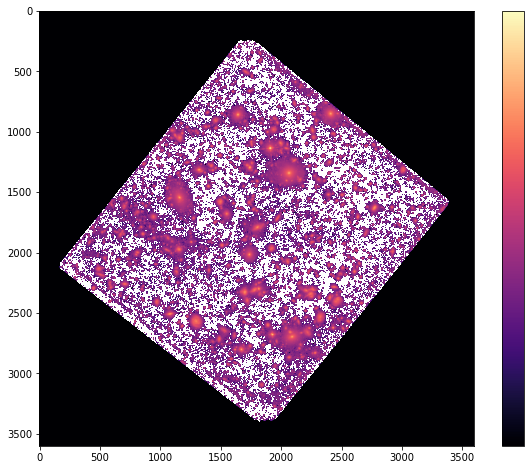

In [74]:
plt.imshow(image_data, cmap='magma', norm=LogNorm())

# Choose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

In [70]:
# make a list of filenames
image_list = ['hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits']

In [75]:
#make an array of images from the list of images
image_concat = [fits.getdata(image) for image in image_list]

In [76]:
#sum the images together
final_image = np.sum(image_concat, axis=0)

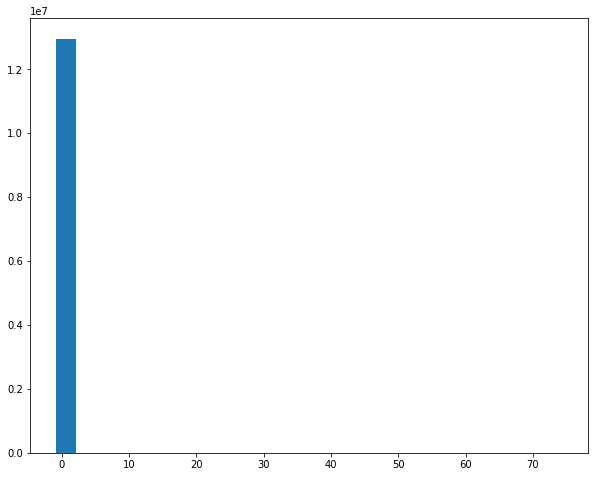

In [78]:
#plot a histogram of the image pixel values
image_hist = plt.hist(final_image.flatten(), bins='auto')

## Control the box size

In [55]:
bkg = sep.Background(image_data)

In [56]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [57]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

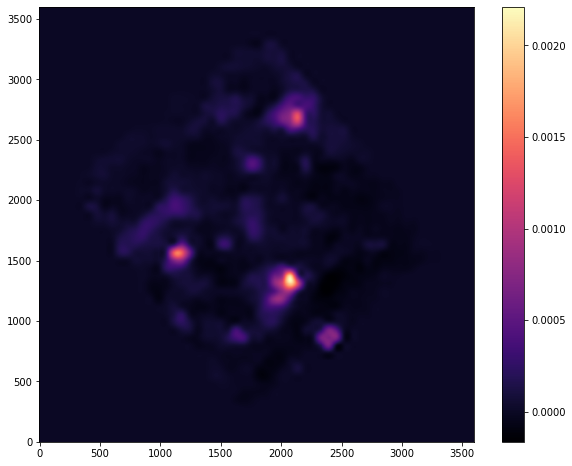

In [58]:
# show the background of the image
plt.imshow(bkg_image, interpolation='nearest', cmap='magma', origin='lower')
plt.colorbar();

In [59]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

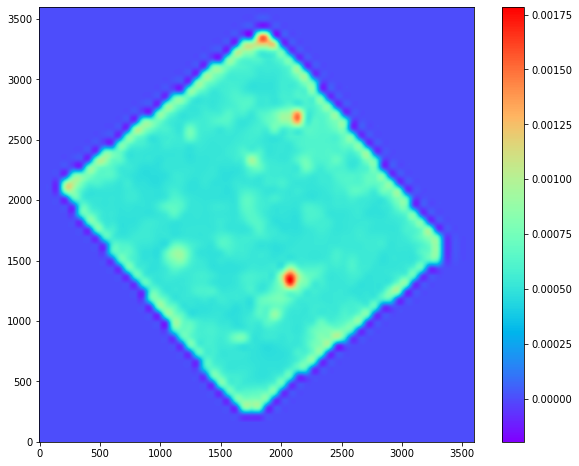

In [60]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='rainbow', origin='lower')
plt.colorbar();

In [61]:
# subtract the background
data_sub = image_data - bkg

## Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS.

In [62]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

#sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending.

In [63]:
# how many objects were detected
len(objects)

8640

## objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image

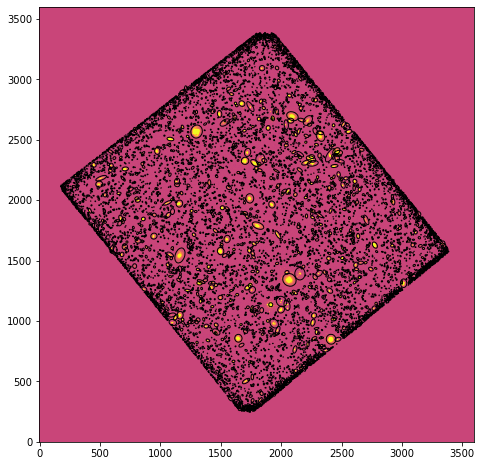

In [64]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='plasma',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('black')
    ax.add_artist(e)

## objects has many fields, gives information such as second moments,peak pixel position and values

In [65]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## We’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects

In [66]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)


In [67]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
